<a href="https://colab.research.google.com/github/jimitogni/brain_tumors/blob/main/Ex06_226359.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Deep Learning para detecção de tumores no cérebro

In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms #testar dense
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Carregar dados

Este código carrega imagens 2D de cérebros saudáveis e cérebros contendo tumores usando um dataloader.

In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=6) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cuda', index=0)

In [ ]:
print(dataset_sizes)

{'train': 143, 'val': 62, 'test': 48}


# Visualizando algumas imagens (um batch)

Batch of training data


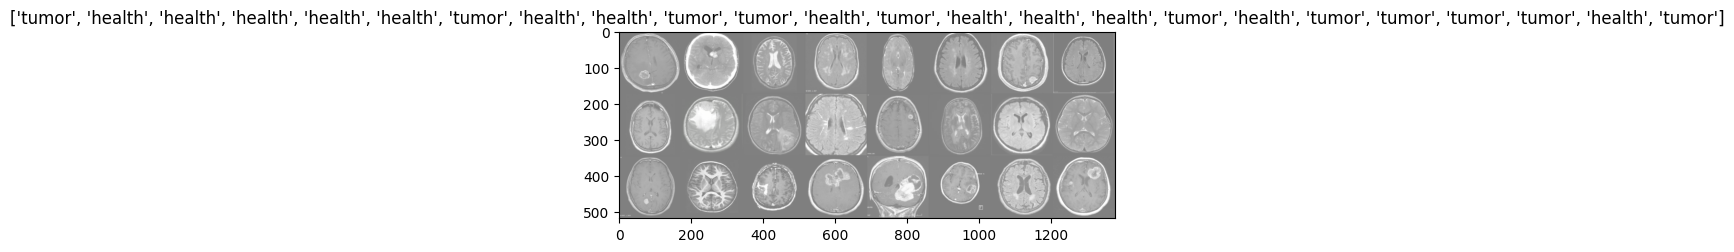

Batch of validation data


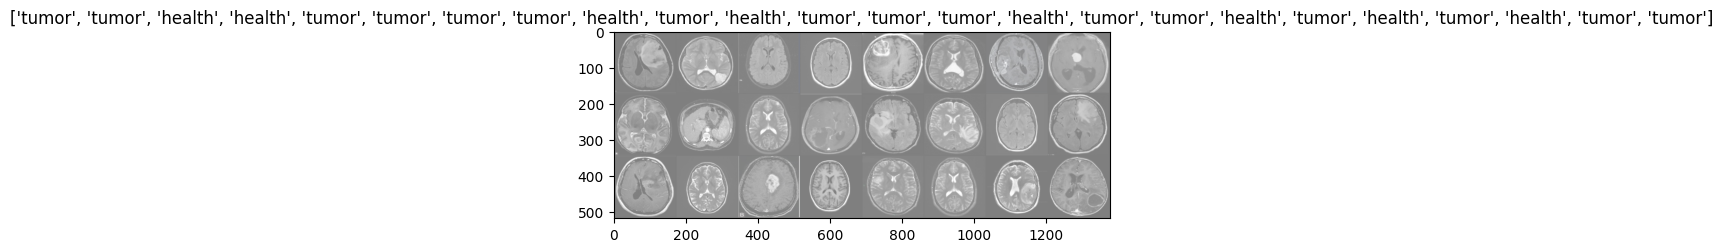

Batch of test data


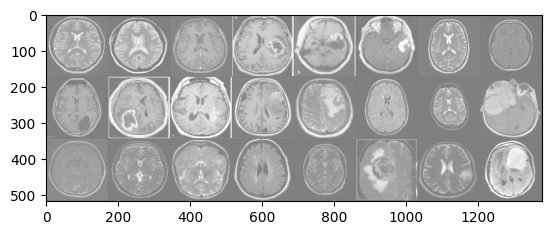

('gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test16.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test36.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test7.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test40.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test38.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test43.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test17.jpeg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test15.jpeg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test2.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test29.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test30.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex0

In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

# Treinando o modelo

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Testando o modelo

In [ ]:
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(50, 50))
                plt.tight_layout() 
                plt.subplot(num_images, 1, images_so_far)
                plt.axis('off')
                print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Experiment 1

**No transfer learning:** Random initialization and all weights will be retrained.

In [ ]:
model_ft_randstart = models.resnet18(pretrained=False)
num_ftrs = model_ft_randstart.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_randstart.fc = nn.Linear(num_ftrs, 2)

model_ft_randstart = model_ft_randstart.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.0003, momentum=0.9) #lr 0.0008?

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.01)

In [ ]:
model_ft_randstart

In [ ]:
summary(model_ft_randstart, (3, 170, 170))

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=99)

Epoch 0/98
----------
train Loss: 0.7537 Acc: 0.4196
val Loss: 0.6713 Acc: 0.6613

Epoch 1/98
----------
train Loss: 0.6710 Acc: 0.6364
val Loss: 0.6398 Acc: 0.6613

Epoch 2/98
----------
train Loss: 0.6644 Acc: 0.6294
val Loss: 0.6409 Acc: 0.6613

Epoch 3/98
----------
train Loss: 0.6160 Acc: 0.6503
val Loss: 0.6664 Acc: 0.6613

Epoch 4/98
----------
train Loss: 0.5893 Acc: 0.7762
val Loss: 0.6661 Acc: 0.6613

Epoch 5/98
----------
train Loss: 0.5633 Acc: 0.7273
val Loss: 0.6458 Acc: 0.6613

Epoch 6/98
----------
train Loss: 0.5383 Acc: 0.7063
val Loss: 0.6370 Acc: 0.6613

Epoch 7/98
----------
train Loss: 0.5256 Acc: 0.7133
val Loss: 0.6287 Acc: 0.6935

Epoch 8/98
----------
train Loss: 0.5022 Acc: 0.7622
val Loss: 0.6126 Acc: 0.7097

Epoch 9/98
----------
train Loss: 0.4925 Acc: 0.7902
val Loss: 0.5795 Acc: 0.7097

Epoch 10/98
----------
train Loss: 0.4768 Acc: 0.8601
val Loss: 0.5693 Acc: 0.7903

Epoch 11/98
----------
train Loss: 0.4573 Acc: 0.8601
val Loss: 0.5547 Acc: 0.7581

Ep

path: test41.jpg / predicted: tumor


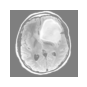

path: test46.JPG / predicted: tumor


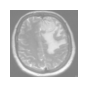

path: test8.jpg / predicted: tumor


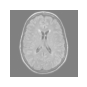

path: test15.jpeg / predicted: health


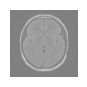

path: test39.JPG / predicted: tumor


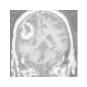

path: test22.jpg / predicted: health


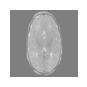

path: test30.JPG / predicted: tumor


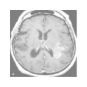

path: test29.JPG / predicted: tumor


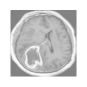

path: test26.jpg / predicted: tumor


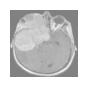

path: test28.jpg / predicted: tumor


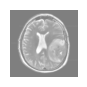

path: test6.JPG / predicted: tumor


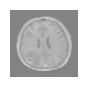

path: test34.JPG / predicted: tumor


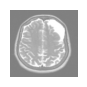

path: test27.jpg / predicted: tumor


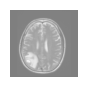

path: test31.JPG / predicted: tumor


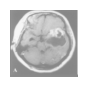

path: test3.jpg / predicted: tumor


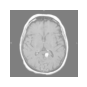

path: test2.jpg / predicted: tumor


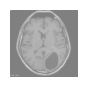

path: test14.jpg / predicted: health


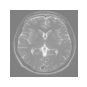

path: test16.jpg / predicted: tumor


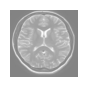

path: test10.JPG / predicted: tumor


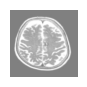

path: test18.jpg / predicted: tumor


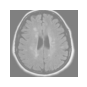

path: test36.JPG / predicted: tumor


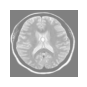

path: test37.JPG / predicted: tumor


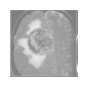

path: test33.JPG / predicted: tumor


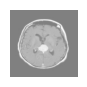

path: test48.JPG / predicted: health


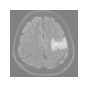

path: test13.jpg / predicted: health


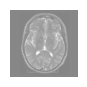

path: test20.jpg / predicted: health


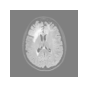

path: test5.jpg / predicted: tumor


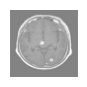

path: test40.JPG / predicted: tumor


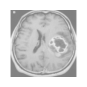

path: test4.jpg / predicted: tumor


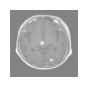

path: test7.JPG / predicted: tumor


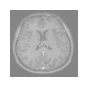

path: test11.jpg / predicted: health


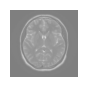

path: test43.JPG / predicted: tumor


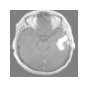

path: test42.jpg / predicted: tumor


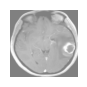

path: test1.jpg / predicted: tumor


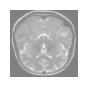

path: test25.jpg / predicted: tumor


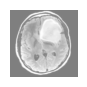

path: test23.jpeg / predicted: health


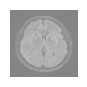

path: test47.JPG / predicted: tumor


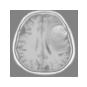

path: test21.jpg / predicted: health


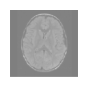

path: test38.JPG / predicted: tumor


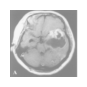

path: test32.JPG / predicted: tumor


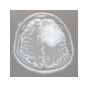

path: test44.JPG / predicted: tumor


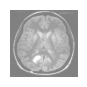

path: test19.png / predicted: tumor


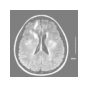

path: test24.jpg / predicted: tumor


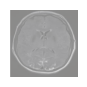

path: test9.JPG / predicted: health


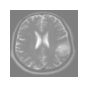

path: test17.jpeg / predicted: health


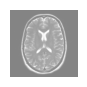

path: test12.jpg / predicted: health


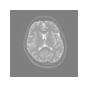

path: test45.JPG / predicted: tumor


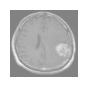

path: test35.JPG / predicted: tumor


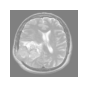

In [ ]:
test_model(model_ft_randstart)

# Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('path:{} predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

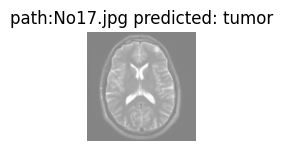

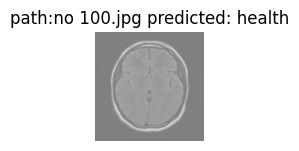

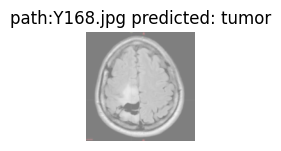

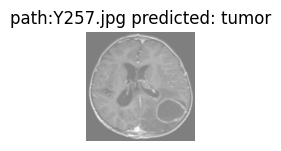

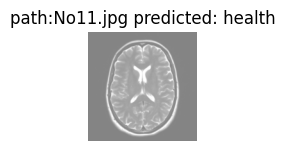

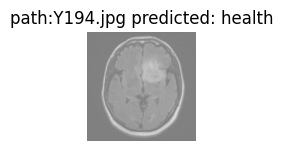

In [ ]:
visualize_model(model_ft_randstart)